In [ ]:
import sys
import copy
from einops import rearrange
import numpy as np
import numpy.random as rn
from scipy.special import softmax
from numpy import linalg
from scipy.optimize import linprog  
sys.path.append('../..')
from examples.safe_PCE import *
random.seed(10)
np.random.seed(10)

In [15]:
def Sample_CMDP(env, policy, counts_sa, counts_sa2s):
    state = rn.choice(env.n, p = env.nu0)
    for _ in range(600):
        action = np.random.choice(env.m, p = policy[state, :])
        next_state= np.random.choice(env.n, p = env.P[state, action, :]) 
        counts_sa[state, action] += 1
        counts_sa2s[state, action, next_state] += 1
        state = next_state
        # reach the absorbing state, break
        if next_state == 45:
            for action in range(env.m):
                counts_sa[next_state, action] += 1
                counts_sa2s[next_state, action, next_state] += 1
            break
    return counts_sa, counts_sa2s

def Etimate_P_Confidence_dope_plus(env, counts_sa, counts_sa2s):
    # Estimate transition probabilities and confidence intervals
    P_est = np.zeros((env.n, env.m, env.n))
    confidence = np.zeros((env.n, env.m))
    confidence_p = np.zeros((env.n, env.m, env.n))
    # L = np.log2( env.n * env.m * 40000 / (0.1 * (1 - env.gamma))) Not working, it is too large and the confidence_p is too big, and it makes solution returned from the LP is actually infeasible in real env
    # now try to find the best L through tuning, and differentiate L for confidence and confidence_p, as confidence_p and confidence prefers smaller value
    L_p = 1e-08
    L = 1e-04
    K = 40000
    for s in range(env.n):
        for a in range(env.m):
            epsilon = np.sqrt(4 * L * env.n / max(1, counts_sa[s, a] -1 )) + 14 * L * env.n / (3 * max(1, counts_sa[s, a] - 1))
            confidence[s, a] = epsilon * 8 / np.sqrt(1 - env.gamma)  + L * 2 * np.sqrt(K /((1 - env.gamma) * env.m ))/ (max(1, counts_sa[s, a] - 1)) # original has 4 * env.n * np.sqrt(env.m /((1 - env.gamma) * K)), but it is too large(6)
            if counts_sa[s, a] > 0:
                for s_next in range(env.n):
                    P_est[s, a, s_next] = counts_sa2s[s, a, s_next] / counts_sa[s, a]
            else:
                P_est[s, a, :] = np.ones(env.n) / env.n

            confidence_p[s, a, :] = np.sqrt(4 * L_p * P_est[s, a, :] / max(1, counts_sa[s, a] -1 )) + 14 * L_p / (3 * max(1, counts_sa[s, a] - 1))
        

    return P_est, confidence, confidence_p

def LP_solve_dope_plus(env, P_est, confidence, confidence_p):
    # L = np.log2(10 * env.n * env.m * 40000 / (0.1 * (1 - env.gamma))) not working
    L = 5e-04
    r = env.r.copy()
    r = np.minimum(r + confidence/(0.1 * (1 - env.gamma)), (1 + np.sqrt(L)) * np.ones_like(r) ) # since r only takes values 1 at one point, this function only changes vakue at that point. It is not change the optimal policy
    r = rearrange(r, 's a -> (s a)')
    Psi = env.Psi.copy()
    Psi[:, :, 0] += confidence
    Psi = rearrange(Psi, 's a k-> (s a) k')
    
    # Construct the flow conservation constraint matrix
    # For each state s: sum_a d(s,a) - gamma * sum_{s',a'} P(s|s',a') * d(s',a') = (1-gamma) * nu0(s)
    A_eq = np.zeros((env.n, env.n * env.m))
    for s in range(env.n):
        # Outflow: sum_a d(s,a)
        A_eq[s, s * env.m:(s + 1) * env.m] = 1
        # Inflow: -gamma * sum_{s',a'} P(s|s',a') * d(s',a')
        for sp in range(env.n):
            for ap in range(env.m):
                idx = sp * env.m + ap
                A_eq[s, idx] -= env.gamma * P_est[sp, ap, s]
    
    b_eq = (1 - env.gamma) * env.nu0
    
    # Sum confidence_p over the next state dimension to get (env.n,) shape
    confidence_p_sum = np.sum(confidence_p, axis=2)  # Shape: (env.n, env.m)
    # Then sum over actions to get per-state confidence
    confidence_per_state = np.sum(confidence_p_sum, axis=1)  # Shape: (env.n,)

    # 1. Create the first inequality from the original equality: A_eq @ x <= b_eq + confidence
    A_from_eq_1 = A_eq
    b_from_eq_1 = b_eq + confidence_per_state

    # 2. Create the second inequality: -A_eq @ x <= -b_eq + confidence
    A_from_eq_2 = -A_eq
    b_from_eq_2 = -b_eq + confidence_per_state
    
    A_ub = Psi.T / (1-env.gamma)
    b_ub = env.b

    new_A_ub = np.vstack([A_ub, A_from_eq_1, A_from_eq_2])
    new_b_ub = np.concatenate([b_ub, b_from_eq_1, b_from_eq_2])

    # 4. Solve the linear program with the new set of inequality constraints
    # and no equality constraints.
    sol = linprog(-r / (1 - env.gamma), A_ub = new_A_ub, b_ub = new_b_ub, bounds=(0, None))
    
    if sol.x is None or not sol.success:
        return None, sol
    # Manually convert vector to tensor format (s, a) shape
    occ_tensor = rearrange(sol.x, '(s a) -> s a', a=env.m)
    return env.occ2policy(occ_tensor), sol

def DOPE_plus(env, pi_s, max_iters = 30000):
    counts_sa = np.zeros((env.n, env.m))
    counts_sa2s = np.zeros((env.n, env.m, env.n))
    _, u_optimal, _ = LP(env)
    reward_regret = np.zeros(max_iters)
    cost_hist = np.zeros(max_iters)
    r_s, c_s = value_function_r_c(env, pi_s)
    for it in range(max_iters):
        # safe exploration phase to collect data
        if it < 18000:#too small number will lead to infeasible LP later and back to safe policy or directly unsafe policy
            counts_sa, counts_sa2s = Sample_CMDP(env, pi_s, counts_sa, counts_sa2s)
            reward_regret[it] = (u_optimal - r_s) * (it + 1)
            cost_hist[it] = np.asarray(c_s).ravel()[0]
        else:
            # estimate transition
            P_est, confidence, confidence_p = Etimate_P_Confidence_dope_plus(env, counts_sa, counts_sa2s)
            # update policy using estimated transition
            policy, sol = LP_solve_dope_plus(env, P_est, confidence, confidence_p)
            if sol.x is None or not sol.success:
                print(f"At iteration {it}, LP failed, using safe policy")
                policy = pi_s  # fallback to safe policy if LP fails
            counts_sa, counts_sa2s = Sample_CMDP(env, policy, counts_sa, counts_sa2s)
            r_s, c_s = value_function_r_c(env, policy)
            reward_regret[it] = (u_optimal - r_s) + reward_regret[it - 1]
            cost_hist[it] = np.asarray(c_s).ravel()[0]
            if cost_hist[it] > env.b:
                print(f"Iteration {it}, constraint violated: cost = {cost_hist[it]}")
                break
    return reward_regret, cost_hist

Saved r_dope and c_dope to data/r_c_history_dope_plus.pkl


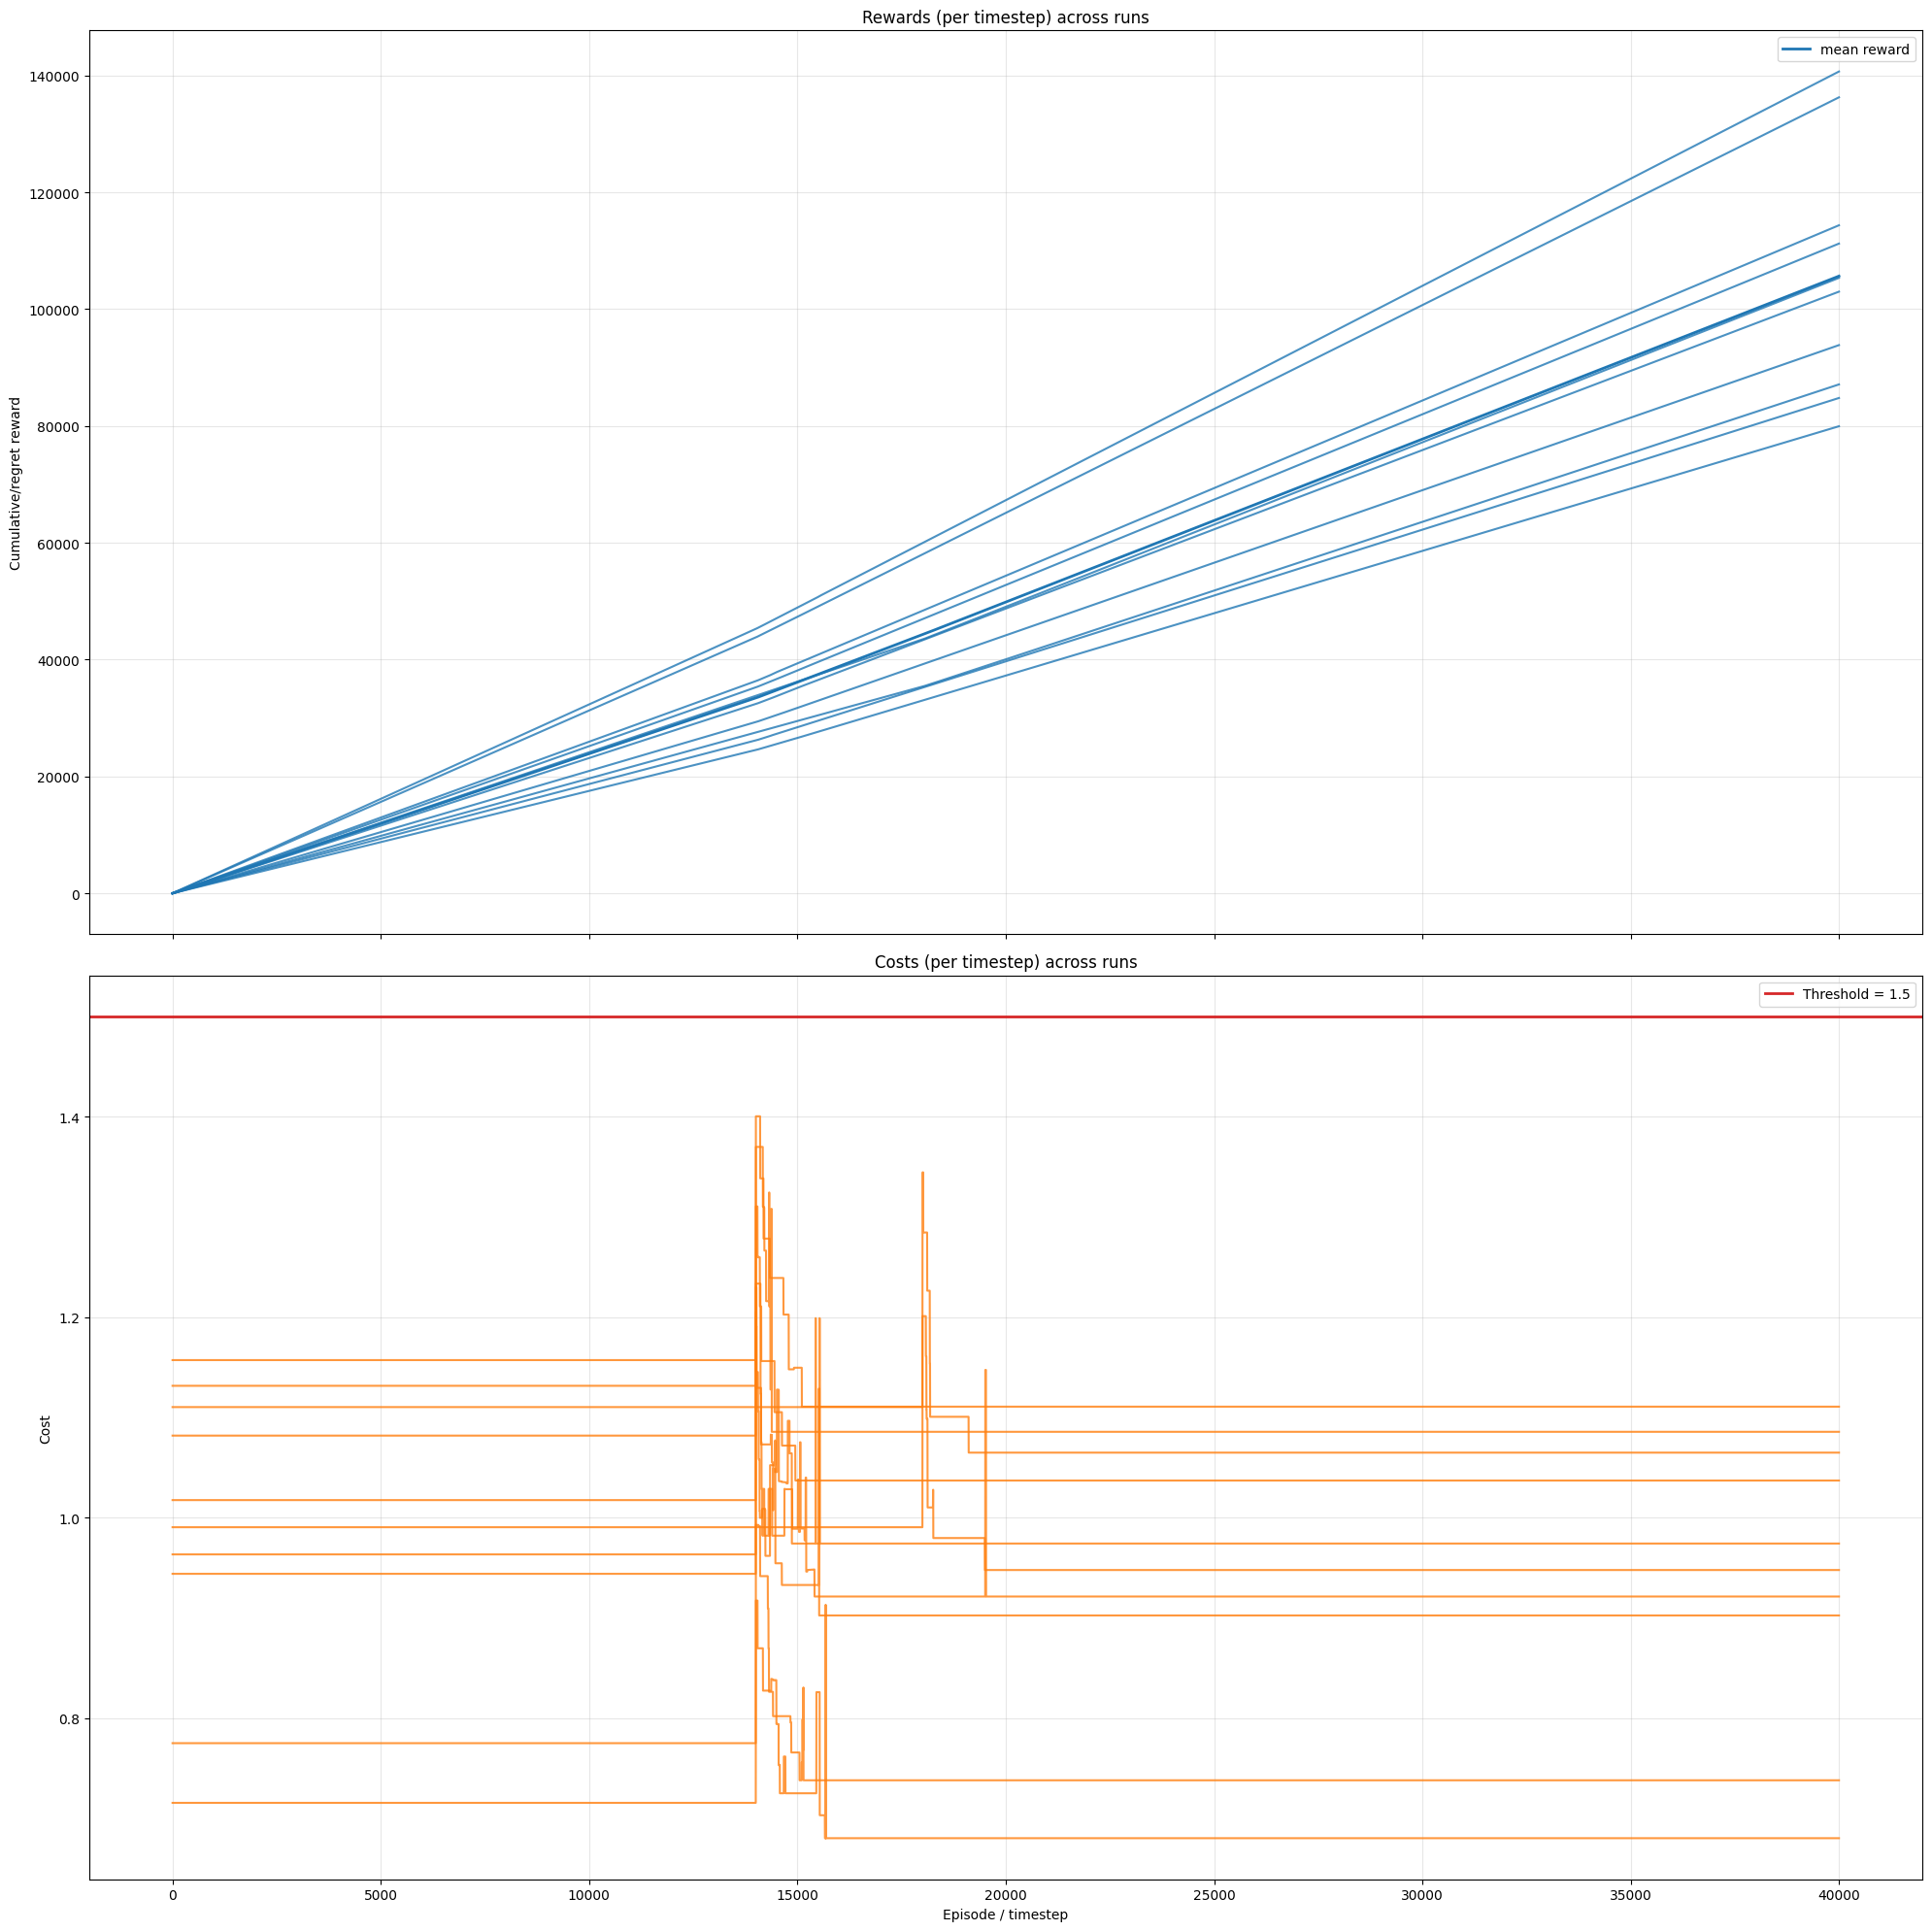

In [16]:
noise_arr = [0.33994760, 0.25363799, 0.31864008, 0.30796535, 0.33609112, 0.33084822, 0.31335413, 0.30405411, 0.34453611, 0.26760585]
# Constrauct safe policy with high entropy such that it encourages exploration for policy gradient approach
env = make_env(0.4)  
pi_s, u_s, v_s = LP(env)
tot_e = 40000
# r_dope = np.zeros((len(noise_arr), tot_e))   # use tuple shape
# c_dope = np.zeros((len(noise_arr), tot_e)) 

for i in [4,6]:
    noise = noise_arr[i]
    env = make_env(noise)
    r_dope[i, :], c_dope[i, :] = DOPE_plus(env, pi_s, tot_e)
with open("data/r_c_history_dope_plus.pkl", "wb") as f:  # Save as a pickle file
    pickle.dump({"r_dope": r_dope, "c_dope": c_dope}, f)
print("Saved r_dope and c_dope to data/r_c_history_dope_plus.pkl")

# Plot reward and cost histories (handles multiple runs)
n_runs, T = r_dope.shape

fig, axes = plt.subplots(2, 1, figsize=(20, 20), sharex=True)

x = np.arange(T)

# Rewards
for i in range(n_runs):
	axes[0].plot(x, r_dope[i], color='C0', alpha=0.8)
axes[0].plot(x, np.mean(r_dope, axis=0), color='C0', lw=2, label='mean reward')
axes[0].set_ylabel('Cumulative/regret reward')
axes[0].set_title('Rewards (per timestep) across runs')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Costs
for i in range(n_runs):
	axes[1].plot(x, c_dope[i], color='C1', alpha=0.8)
axes[1].set_ylabel('Cost')
axes[1].set_xlabel('Episode / timestep')
axes[1].set_title('Costs (per timestep) across runs')
axes[1].axhline(y =  1.5, color = 'tab:red',label = 'Threshold = 1.5', linewidth=2)
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig("plots/reg_and_cost_dope_plus.png", format='png', dpi=800)  # Save with 800 dpi
plt.show()